In [1]:
import torch
import torch.optim as optim
import torch.nn as nn
import os
import numpy as np
from PIL import Image
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt

In [17]:
class MultiLabelCNN(nn.Module):
    def __init__(self, conv_params, fc_layers, activation_fn, pooling_type, epochs, batch_size, learning_rate, dropout_rate=0.5, optimizer_choice="adam"):
        super(MultiLabelCNN, self).__init__()

        # Hyperparameters
        self.conv_params = conv_params
        self.activation_fn = activation_fn
        self.pooling_type = pooling_type
        self.dropout_rate = dropout_rate
        self.optimizer_choice = optimizer_choice
        self.epochs = epochs
        self.batch_size = batch_size
        self.learning_rate = learning_rate
        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

        # Convolutional layers
        self.conv_layers = nn.ModuleList()
        for i in range(1, len(conv_params)):
            in_ch = conv_params[i - 1][0]
            out_ch = conv_params[i][0]
            kernel_sz = conv_params[i][1]
            stride = conv_params[i][2]
            self.conv_layers.append(nn.Conv2d(in_ch, out_ch, kernel_sz, stride=stride, padding=1))

        # Fully connected layers
        self.fc_layers = nn.ModuleList()
        for i in range(len(fc_layers) - 1):
            self.fc_layers.append(nn.Linear(fc_layers[i], fc_layers[i + 1]))

        # Dropout
        self.dropout = nn.Dropout(p=self.dropout_rate)

    def apply_activation(self, x):
        if self.activation_fn == "relu":
            return nn.ReLU()(x)
        elif self.activation_fn == "sigmoid":
            return nn.Sigmoid()(x)
        elif self.activation_fn == "tanh":
            return nn.Tanh()(x)
        else:
            return x

    def forward(self, x):
        for layer in self.conv_layers:
            x = layer(x)
            x = self.apply_activation(x)
            x = nn.MaxPool2d(kernel_size=2, stride=2)(x)

        x = torch.flatten(x, start_dim=1)

        print(x.shape)

        for layer in self.fc_layers[:-1]:
            x = layer(x)
            x = self.apply_activation(x)
            x = self.dropout(x)

        x = self.fc_layers[-1](x)
        return x

    def configure_optimizer(self):
        if self.optimizer_choice == "adam":
            return optim.Adam(self.parameters(), lr=self.learning_rate)
        elif self.optimizer_choice == "sgd":
            return optim.SGD(self.parameters(), lr=self.learning_rate, momentum=0.9)
        elif self.optimizer_choice == "rmsprop":
            return optim.RMSprop(self.parameters(), lr=self.learning_rate)

    def train_model(self, train_loader, val_loader):
        training_losses = []
        validation_losses = []
        self.to(self.device)

        loss_function = nn.BCEWithLogitsLoss()
        optimizer = self.configure_optimizer()

        for epoch in range(self.epochs):
            epoch_loss = 0.0
            for batch in train_loader:
                inputs, labels = batch
                inputs, labels = inputs.to(self.device), labels.to(self.device)

                optimizer.zero_grad()
                outputs = self.forward(inputs)
                loss = loss_function(outputs, labels)
                loss.backward()
                optimizer.step()

                epoch_loss += loss.item()

            avg_train_loss, _, _ = self.evaluate_model(train_loader)
            avg_val_loss, _, _ = self.evaluate_model(val_loader)
            print(f"Epoch [{epoch + 1}/{self.epochs}], Train Loss: {avg_train_loss:.6f}, Validation Loss: {avg_val_loss:.6f}")
            training_losses.append(avg_train_loss)
            validation_losses.append(avg_val_loss)

        print('Training Complete')
        return training_losses, validation_losses

    def evaluate_model(self, data_loader):
        self.to(self.device)
        self.eval()

        loss_function = nn.BCEWithLogitsLoss()
        total_loss = 0.0
        all_labels = []
        all_preds = []

        with torch.no_grad():
            for inputs, labels in data_loader:
                inputs, labels = inputs.to(self.device), labels.to(self.device)
                outputs = self.forward(inputs)
                loss = loss_function(outputs, labels)
                total_loss += loss.item()

                probabilities = torch.sigmoid(outputs)
                predictions = (probabilities > 0.3).float()
                all_labels.append(labels.cpu())
                all_preds.append(predictions.cpu())

        avg_loss = total_loss / len(data_loader)
        all_labels = torch.cat(all_labels, dim=0)
        all_preds = torch.cat(all_preds, dim=0)
        correct_preds = (all_preds == all_labels).float().sum()
        total_elements = all_labels.numel()
        overall_accuracy = 100 * correct_preds / total_elements

        exact_matches = (all_preds == all_labels).all(dim=1).float()
        exact_match_accuracy = 100 * exact_matches.sum() / len(exact_matches)

        return avg_loss, overall_accuracy.item(), exact_match_accuracy.item()


In [7]:
def load_images_and_labels(root_dir, data_type):
        images, labels = [], []
        for root, _, files in os.walk(root_dir):
            if data_type in root:
                for file in files:
                    image_path = os.path.join(root, file)
                    image = np.asarray(Image.open(image_path), dtype=float)
                    label_vec = np.zeros(33)
                    # Label encoding based on filename
                    for idx, char in enumerate(root.split(os.sep)[-1][:3]):
                        if char.isdigit():
                            label_vec[idx * 11 + int(char)] = 1
                    images.append(image)
                    labels.append(label_vec)
        return np.asarray(images), np.asarray(labels)

def load_custom_data(data_dir):

    images_train, labels_train = load_images_and_labels(data_dir, "train")
    images_test, labels_test = load_images_and_labels(data_dir, "test")
    images_val, labels_val = load_images_and_labels(data_dir, "val")

    def create_tensor_dataset(images, labels):
        images_tensor = torch.from_numpy(images).float().unsqueeze(1)
        labels_tensor = torch.from_numpy(labels)
        return TensorDataset(images_tensor, labels_tensor)

    train_loader = DataLoader(create_tensor_dataset(images_train, labels_train), batch_size=32, shuffle=True)
    test_loader = DataLoader(create_tensor_dataset(images_test, labels_test), batch_size=32, shuffle=False)
    val_loader = DataLoader(create_tensor_dataset(images_val, labels_val), batch_size=32, shuffle=False)
    
    return train_loader, test_loader, val_loader

In [8]:
data_dir = "../../data/external/double_mnist"
train_loader, test_loader, val_loader = load_custom_data(data_dir)

Epoch [1/5], Train Loss: 0.190710, Validation Loss: 0.209163
Epoch [2/5], Train Loss: 0.094679, Validation Loss: 0.175653
Epoch [3/5], Train Loss: 0.041327, Validation Loss: 0.161053
Epoch [4/5], Train Loss: 0.027086, Validation Loss: 0.191410
Epoch [5/5], Train Loss: 0.009486, Validation Loss: 0.193525
Training Complete
Validation - Loss: 0.1935, Hamming Accuracy: 96.1111, Exact Match Accuracy: 29.2667


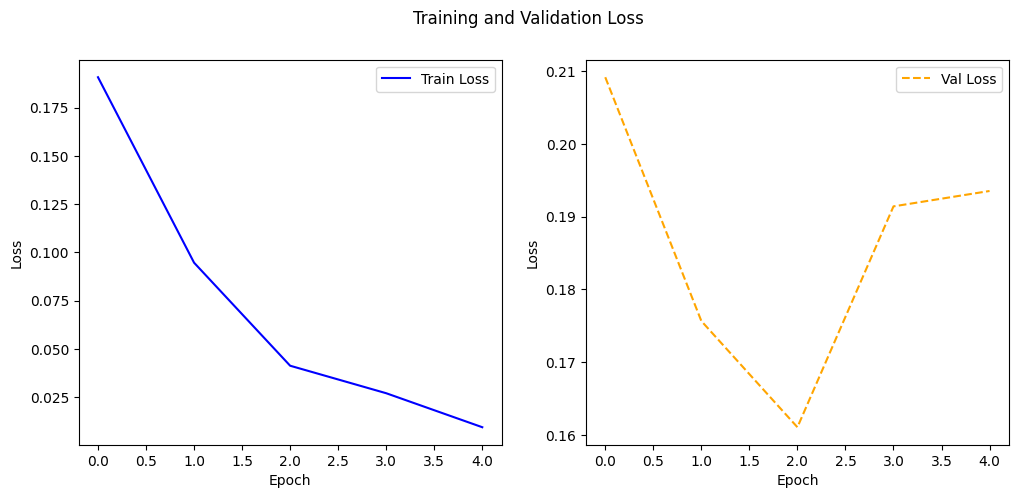

In [12]:
conv_params = [
    (1, 0, 0),
    (32, 3, 1),
    (64, 3, 1),
    (128, 3, 1)
]
fc_layers = [32768, 256, 33]

cnn_model = MultiLabelCNN(conv_params, fc_layers, activation_fn='relu', pooling_type='max', epochs=5, batch_size=32, learning_rate=0.001, dropout_rate=0.5, optimizer_choice="adam")
train_losses, val_losses = cnn_model.train_model(train_loader, val_loader)

val_loss, val_acc, val_exact_acc = cnn_model.evaluate_model(val_loader)
print(f"Validation - Loss: {val_loss:.4f}, Hamming Accuracy: {val_acc:.4f}, Exact Match Accuracy: {val_exact_acc:.4f}")

# Plot training and validation loss
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
ax1.plot(train_losses, label="Train Loss", color='blue')
ax1.set_xlabel("Epoch")
ax1.set_ylabel("Loss")
ax1.legend()

ax2.plot(val_losses, label="Val Loss", linestyle='--', color='orange')
ax2.set_xlabel("Epoch")
ax2.set_ylabel("Loss")
ax2.legend()

plt.suptitle("Training and Validation Loss")
plt.savefig('./figures/mlc1.png')
plt.show()


Epoch [1/5], Train Loss: 0.268616, Validation Loss: 0.282359
Epoch [2/5], Train Loss: 0.254499, Validation Loss: 0.271925
Epoch [3/5], Train Loss: 0.245721, Validation Loss: 0.265571
Epoch [4/5], Train Loss: 0.237930, Validation Loss: 0.258984
Epoch [5/5], Train Loss: 0.230699, Validation Loss: 0.254289
Training Complete
Validation - Loss: 0.2543, Hamming Accuracy: 88.6192, Exact Match Accuracy: 0.1333


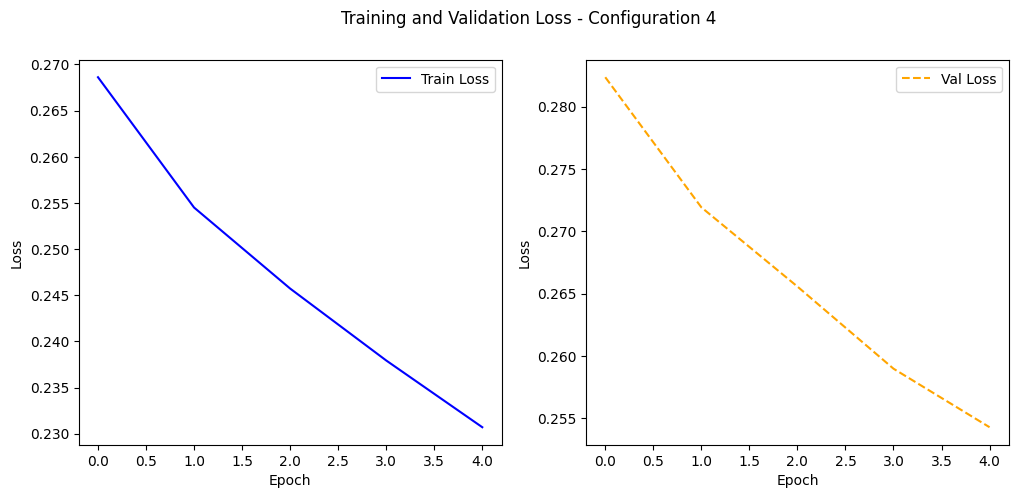

In [16]:
conv_params_4 = [
    (1, 0, 0),
    (64, 3, 1),
    (128, 3, 1),
    (256, 3, 1)
]
fc_layers_4 = [65536, 256, 33]

cnn_model_4 = MultiLabelCNN(
    conv_params_4,
    fc_layers_4,
    activation_fn='relu',
    pooling_type='avg',
    epochs=5,
    batch_size=16,
    learning_rate=0.0001,
    dropout_rate=0.6,
    optimizer_choice="sgd"
)
train_losses_4, val_losses_4 = cnn_model_4.train_model(train_loader, val_loader)
# Evaluate the model
val_loss_4, val_acc_4, val_exact_acc_4 = cnn_model_4.evaluate_model(val_loader)
print(f"Validation - Loss: {val_loss_4:.4f}, Hamming Accuracy: {val_acc_4:.4f}, Exact Match Accuracy: {val_exact_acc_4:.4f}")

# Plot training and validation loss
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
ax1.plot(train_losses_4, label="Train Loss", color='blue')
ax1.set_xlabel("Epoch")
ax1.set_ylabel("Loss")
ax1.legend()

ax2.plot(val_losses_4, label="Val Loss", linestyle='--', color='orange')
ax2.set_xlabel("Epoch")
ax2.set_ylabel("Loss")
ax2.legend()

plt.suptitle("Training and Validation Loss - Configuration 4")
plt.savefig('./figures/mlc5.png')
plt.show()
